
# COS30049 - Workshop Week 4  
### Swinburne Univeristy of Technology

### Objective

By the end of this workshop, participants will have a solid grasp of the Machine Learning Project Lifecycle and the ability to use Python within Visual Studio Code for data processing. The workshop focuses on practical skills, including handling outliers, addressing missing data, and utilizing Python's regular expressions for text data extraction and manipulation.
Learning Outcomes:
1.	Proficiency in Outlier Management: Learn to identify and manage outliers, ensuring data integrity and accuracy in your analysis.
2.	Strategies for Handling Missing Data: Develop effective techniques for addressing missing data, including imputation and other methods.
3.	Mastering Python’s Regular Expressions: Gain expertise in using Python's regular expressions to extract and manipulate text data for analytical purposes.
Hands-on Practice:
Participants will engage in practical exercises and real-world scenarios to apply these techniques, equipping them to confidently tackle data challenges in their own projects.


Before you start, make sure you install the related libary in the terminal.
1. pip install pandas 
2. pip install matplotlib
3. pip install regex

### Question 1  Outlier Management (15 mins)
Suppose that the data for analysis includes the attribute age. The age values for the data tuples are 13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25,
30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70.

*(1)* What is the first quartile (Q1) and the third quartile (Q3) of the data.

*(2)* Show a boxplot of the data

*(3)* What are the outliers of these data? if these data is student age of the high school. How do you deal with these data?



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Given data
age_data = [13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70]

# Create a pandas DataFrame
df = pd.DataFrame(age_data, columns=['age'])

# (1) Calculate Q1 and Q3
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)

print(f"First Quartile (Q1): {Q1}")
print(f"Third Quartile (Q3): {Q3}")

First Quartile (Q1): 20.5
Third Quartile (Q3): 35.0


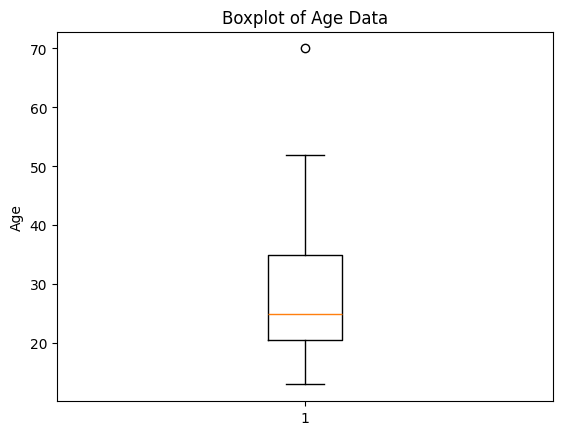

In [2]:
# (2) Show a boxplot of the data
plt.boxplot(df['age'])
plt.title('Boxplot of Age Data')
plt.ylabel('Age')
plt.show()

In [3]:
# (3) Identify outliers
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
print("Outliers:", outliers['age'].tolist())

Outliers: [70]


In [4]:
# (3) If these data are student ages of a high school, deal with outliers
if 70 in outliers['age'].tolist():
    df = df[df['age'] != 70]

print("Data after handling outliers:", df['age'].tolist())

Data after handling outliers: [13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52]


### Q2 - Dealing with Missing data -- (15 mins)

We have a dataset named `sales_data.csv`. Please complete the following tasks:

1. Read the dataset and identify the missing values in the `Sales` and `Profit` columns.
2. Use imputation techniques to fill in the missing values in the dataset. Explain which imputation technique is better.
3. Discuss the impact of the imputed values on subsequent data analysis and decision-making.

In [ ]:
import pandas as pd

# Load dataset
file_path = 'sales_data.csv'
sales_data = pd.read_csv(file_path)

# identifying the missing data
missing_values = sales_data.isnull().sum()

print(missing_values)


FileNotFoundError: [Errno 2] No such file or directory: './sales_data.csv'

In [ ]:
# mean imputation
sales_data_mean_imputed = sales_data.copy()
sales_data_mean_imputed['Sales'].fillna(sales_data['Sales'].mean(), inplace=True)
sales_data_mean_imputed['Profit'].fillna(sales_data['Profit'].mean(), inplace=True)

In [ ]:
sales_data_mean_imputed

In [ ]:
# Mediate Imputation
sales_data_median_imputed = sales_data.copy()
sales_data_median_imputed['Sales'].fillna(sales_data['Sales'].median(), inplace=True)
sales_data_median_imputed['Profit'].fillna(sales_data['Profit'].median(), inplace=True)


In [ ]:
sales_data_median_imputed

Explanation of Which Imputation Technique is Better:

- **Mean Imputation**: This technique is suitable when the data distribution is fairly uniform and there are no extreme values. However, if there are many extreme values, the mean can be affected by these outliers, leading to imputed values that may deviate from the actual data.

- **Median Imputation**: This technique is more appropriate when the data contains extreme values, as the median is not affected by outliers and can provide more stable imputed values.

### Q3 - Regular Expression - (40 mins)


1. Tasks today:

- **Importing Regular Expression Package**:
  `import re`

In [ ]:
# import re
import re

- **Using Regular Expressions**: Regular expressions give us the ability to search for patterns within text, strings, files, etc. They serve several uses, such as; security measures, searching, filtering, pattern recognition, and more... \\
  a) `re.compile()` : using compile, pre determines the string to be used in regular expression methods. \\
  b) `re.match()` :  This method attempts to match a pattern at the beginning of the string. \\
  c) `re.findall` : This method returns a list of all non-overlapping matches of a pattern in the string, as a list of strings. \\
  d) `re.search()` : This method scans through the string, looking for any location where the pattern matches.  \\

In [ ]:
# add pattern abcd
pattern = re.compile('abcd')
print(pattern)

- **Sets**: The following cells will allow you to use regular expressions to search for certain values within a range. \\
  a) Integer Ranges: For example, [0-7] \\
  b) Character Ranges: For exampe, [A-Z][a-z] \\

In [ ]:
# use match() to match abcd123
match = pattern.match('abcd123')
print(match)

In [ ]:
# use this pattern to find '123abcd abcd123 abcd abcabc acb'
finders = pattern.findall('123abcd abcd123 abcd abcabc acb')
print(finders)

In [ ]:
# explain the code blow
random_string = '123 123 234 abcd abc'

search = pattern.search(random_string)
print(search)
span = search.span()
print(span)
print(random_string[span[0] : span[1]])

In [ ]:
# Compile a regular expression pattern [0-7][7-9][0-3] and search for this pattern in the string '67383'.
# If a match is found, print the match object and the character at the start position of the match.
pattern_int = re.compile('[0-7][7-9][0-3]')

random_numbers = pattern_int.search('67383')
print(random_numbers)
span = random_numbers.span()
print(random_numbers[span[0]])

In [ ]:
# Compile a regular expression pattern [A-Z][a-z] to match any sequence of an uppercase letter followed by a lowercase letter.
# Use the findall method to find all such sequences in the string 'Hello there Mr. Ricky' and print the list of matches
char_pattern = re.compile('[A-Z][a-z]')
found = char_pattern.findall('Hello there Mr. Ricky')
print(found)

- **Counting Occurences**: The following cells will allow you to use regular expressions to search for certain values within a range. \\

  a) `{x}` :  something that occurs {num_of_times}. \\
  b) `{, x}` : {x, x} - something that occurs between x and x times  \\
  c) `{?}` : something that occurs 0 or 1 time \\
  d) `{*}` : * - something that occurs at least 0 times \\
  e) `{+}`: + - something that occurs at least once \\



In [ ]:
# Compile a regular expression pattern `[A-Z][a-z][0-3]{2}` to match any sequence of an uppercase letter, a lowercase letter,
# and two digits ranging from 0 to 3. Use the `findall` method to find all such sequences in the string `'Hello Mr. Ri03cky'` and print the list of matches.
char_pattern_count = re.compile('[A-Z][a-z][0-3]{2}')
found_count = char_pattern_count.findall('Hello Mr. Ri03cky')
print(found_count)

In [ ]:
# Compile a regular expression pattern m{1,5} to match any sequence of 1 to 5 consecutive 'm' characters.
# Use the findall method to find all such sequences in the string 'This is an example of a regular expression trying to find one m,
# more than one mmm or five mmmmms' and print the list of matches.
random_pattern = re.compile('m{1,5}')
random_statement = random_pattern.findall('This is an example of a regular expression trying to find one m, more than one mmm or five mmmmms')
print(random_statement)

In [ ]:
# Compile a regular expression pattern Mrss? to match the string 'Mrs' optionally followed by an 's'.
# Use the findall method to find all such sequences in the string 'Hello M there Mr. Anderson, Mid how is Mrs. Anderson, and Mrss. Anderson?'
# and print the list of matches.
pattern = re.compile('Mrss?')
found_pat = pattern.findall('Hello M there Mr. Ricky, Mid how is Mrs. Ricky, and Mrss. Ricky?')
print(found_pat)

- **Escaping Character**:

  a) `\w` :  look for any Unicode character \\
  b) `\W` :  look for anything that isnt a Unicode character \\

  More escaping characters please inspect : https://learn.microsoft.com/en-us/dotnet/standard/base-types/character-escapes-in-regular-expressions

In [ ]:
# Compile two regular expression patterns: [\w]+ to find sequences of word characters and
# [\W]+ to find sequences of non-word characters. Use the findall method to search for these patterns in the string and print the results.
pattern_1 = re.compile('[\w]+')
pattern_2 = re.compile('[\W]+')

found_1 = pattern_1.findall('This is a sentence. With, exclamation mark at the end!')
found_2 = pattern_2.findall('This is a sentence. With, exclamation mark at the end!')

print(found_1)
print(found_2)